In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

F:\OneDrive - Compnet\Storage\Belajar\VENV_JUPITER_3.9\3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 60.3M/60.3M [03:19<00:00, 317kB/s] 

Extracting files...


Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [26]:
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
from skimage.transform import rotate, warp, AffineTransform
from skimage.exposure import adjust_gamma
import shutil
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [86]:
# Direktori awal untuk train dan test
train_dir = r"./Data/train"
test_dir = r"./Data/test"
# Direktori baru untuk dataset gabungan
combined_dir = "chest_xray/dataset"

In [88]:
# Ukuran gambar yang diinginkan
img_height, img_width = 224, 224
batch_size = 32

# Load dataset dari folder
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Data/Train",
    image_size=(img_height, img_width),
    batch_size=batch_size
)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    "Data/Test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Normalisasi nilai pixel agar berada dalam rentang [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 10000 files belonging to 4 classes.
Found 4796 files belonging to 4 classes.


In [89]:
import os
import matplotlib.pyplot as plt

# Direktori train dan test
train_dir = r"./Data/train"
test_dir = r"./Data/test"

# Fungsi untuk menghitung jumlah gambar di setiap kategori
def count_images(directory):
    distribution = {}
    for cls in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):  # Pastikan hanya membaca folder
            distribution[cls] = len(os.listdir(class_path))
    return distribution

# Hitung penyebaran data
train_distribution = count_images(train_dir)
test_distribution = count_images(test_dir)

# Gabungkan train + test untuk melihat total dataset
total_distribution = {cls: train_distribution.get(cls, 0) + test_distribution.get(cls, 0) for cls in set(train_distribution) | set(test_distribution)}

# Tampilkan hasil
print("Distribusi Train:", train_distribution)
print("Distribusi Test:", test_distribution)
print("Distribusi Total:", total_distribution)


Distribusi Train: {'angry': 2500, 'happy': 2500, 'neutral': 2500, 'surprise': 2500}
Distribusi Test: {'angry': 958, 'happy': 1774, 'neutral': 1233, 'surprise': 831}
Distribusi Total: {'surprise': 3331, 'angry': 3458, 'happy': 4274, 'neutral': 3733}


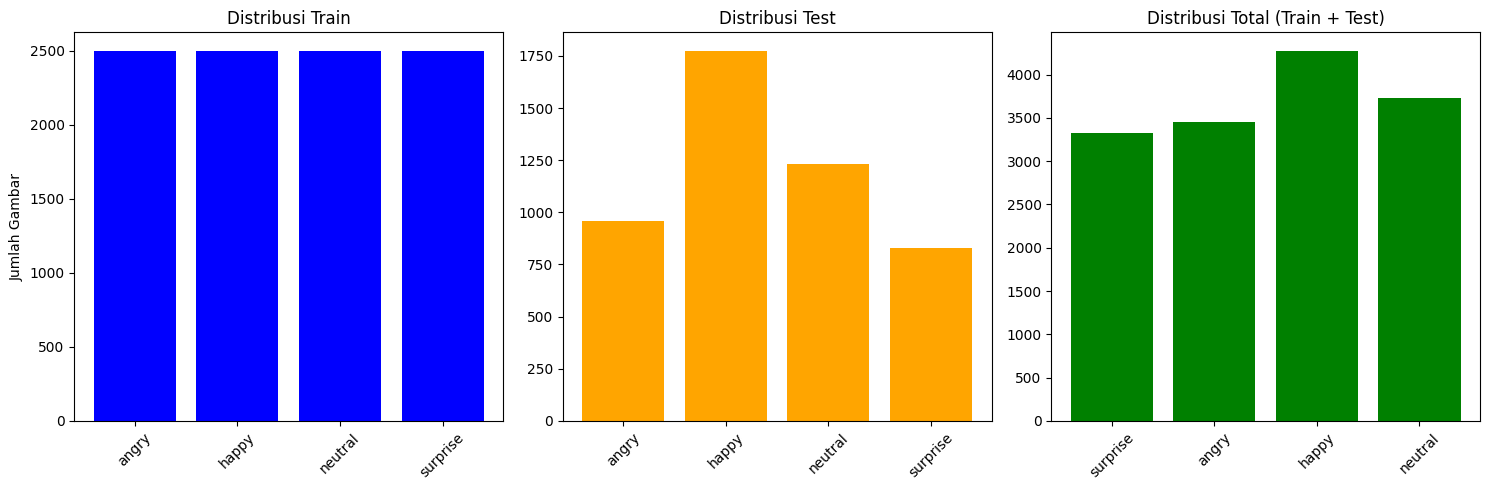

In [90]:
# Buat subplots untuk Train, Test, dan Total
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Train
axs[0].bar(train_distribution.keys(), train_distribution.values(), color='blue')
axs[0].set_title("Distribusi Train")
axs[0].set_ylabel("Jumlah Gambar")
axs[0].tick_params(axis='x', rotation=45)

# Plot Test
axs[1].bar(test_distribution.keys(), test_distribution.values(), color='orange')
axs[1].set_title("Distribusi Test")
axs[1].tick_params(axis='x', rotation=45)

# Plot Total
axs[2].bar(total_distribution.keys(), total_distribution.values(), color='green')
axs[2].set_title("Distribusi Total (Train + Test)")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [123]:
import os
import random
import shutil

train_dir = "./Data/train"
target_size = 100  # Setiap kelas harus punya 1000 gambar

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if not os.path.isdir(class_path):
        continue
    
    images = os.listdir(class_path)
    total_images = len(images)
    
    # Jika gambar lebih dari 1000, pilih random 1000 gambar
    if total_images > target_size:
        images_to_keep = random.sample(images, target_size)
        for img in images:
            if img not in images_to_keep:
                os.remove(os.path.join(class_path, img))
    
    # Jika gambar kurang dari 1000, augmentasi sampai mencukupi
    elif total_images < target_size:
        augment_needed = target_size - total_images
        print(f"Kelas {class_name} perlu ditambah {augment_needed} gambar.")

print(f"Proses sampling selesai! Semua kelas sekarang punya {target_size} gambar.")


Proses sampling selesai! Semua kelas sekarang punya 100 gambar.


In [124]:

# Hitung penyebaran data
train_distribution = count_images(train_dir)
test_distribution = count_images(test_dir)

# Gabungkan train + test untuk melihat total dataset
total_distribution = {cls: train_distribution.get(cls, 0) + test_distribution.get(cls, 0) for cls in set(train_distribution) | set(test_distribution)}

# Tampilkan hasil
print("Distribusi Train:", train_distribution)
print("Distribusi Test:", test_distribution)
print("Distribusi Total:", total_distribution)


Distribusi Train: {'angry': 100, 'happy': 100, 'neutral': 100, 'surprise': 100}
Distribusi Test: {'angry': 958, 'happy': 1774, 'neutral': 1233, 'surprise': 831}
Distribusi Total: {'surprise': 931, 'angry': 1058, 'happy': 1874, 'neutral': 1333}


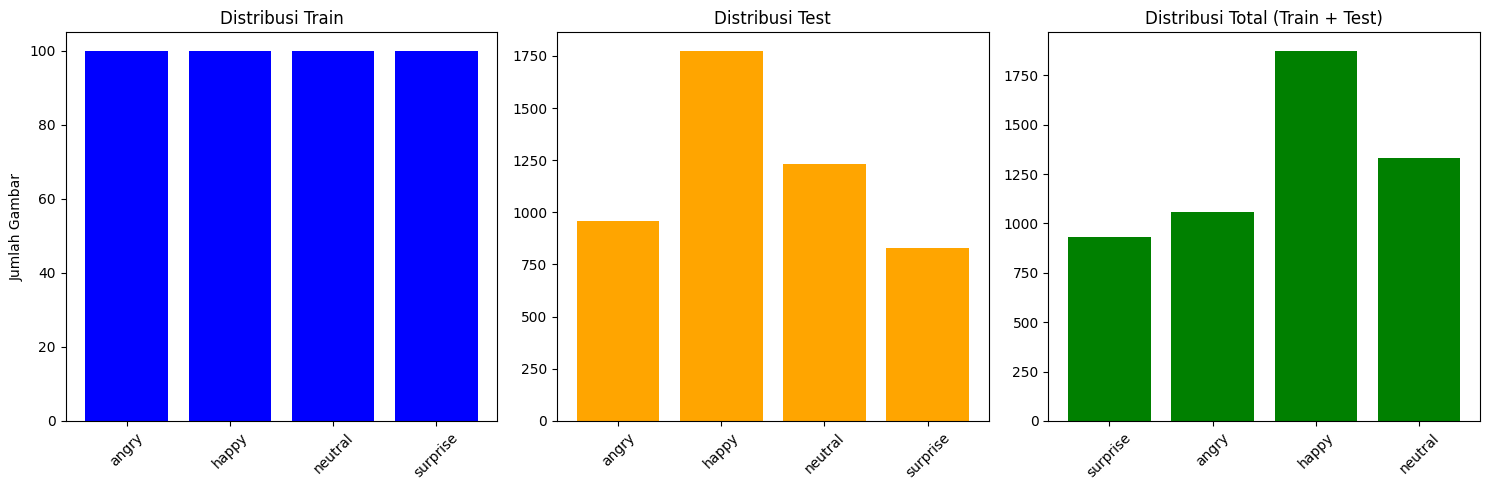

In [125]:
# Buat subplots untuk Train, Test, dan Total
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Train
axs[0].bar(train_distribution.keys(), train_distribution.values(), color='blue')
axs[0].set_title("Distribusi Train")
axs[0].set_ylabel("Jumlah Gambar")
axs[0].tick_params(axis='x', rotation=45)

# Plot Test
axs[1].bar(test_distribution.keys(), test_distribution.values(), color='orange')
axs[1].set_title("Distribusi Test")
axs[1].tick_params(axis='x', rotation=45)

# Plot Total
axs[2].bar(total_distribution.keys(), total_distribution.values(), color='green')
axs[2].set_title("Distribusi Total (Train + Test)")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [187]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "./Data/train"  # Semua data ada di sini

# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% data jadi validation
)

# Generator untuk training (tanpa validation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"  # Hanya ambil data training
)

# Generator untuk validation
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"  # Hanya ambil data validation
)

print("Data train & validation siap! 🚀")


Found 3840 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Data train & validation siap! 🚀


In [229]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Model dengan Dropout untuk mencegah overfitting
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Mengurangi overfitting
    Dense(4, activation='softmax')  # Sesuaikan jumlah kelas
])
# Tampilkan ringkasan model
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 56, 56, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 28, 28, 64)      

In [231]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Stop training jika val_loss tidak membaik selama 5 epoch
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor val_loss, bukan loss training
    patience=5,
    restore_best_weights=True
)

# Kurangi learning rate jika val_loss tidak membaik selama 3 epoch
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor val_loss agar training lebih stabil
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Simpan model terbaik berdasarkan val_loss
model_checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",  # Gunakan val_accuracy
    save_best_only=True
)


# Gabungkan semua callback
callbacks = [early_stopping, reduce_lr, model_checkpoint]


In [233]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Ubah ke categorical_crossentropy
    metrics=['accuracy']
)


In [235]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/25
120/120 [==============================] - 158s 1s/step - loss: 1.4048 - accuracy: 0.2641 - val_loss: 1.3761 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 2/25
120/120 [==============================] - 168s 1s/step - loss: 1.3636 - accuracy: 0.3076 - val_loss: 1.3314 - val_accuracy: 0.3198 - lr: 0.0010
Epoch 3/25
120/120 [==============================] - 164s 1s/step - loss: 1.3258 - accuracy: 0.3643 - val_loss: 1.2983 - val_accuracy: 0.3969 - lr: 0.0010
Epoch 4/25
120/120 [==============================] - 169s 1s/step - loss: 1.3063 - accuracy: 0.3763 - val_loss: 1.2879 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/25
120/120 [==============================] - 157s 1s/step - loss: 1.3036 - accuracy: 0.3794 - val_loss: 1.2913 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 6/25
120/120 [==============================] - 149s 1s/step - loss: 1.2881 - accuracy: 0.3755 - val_loss: 1.2583 - val_accuracy: 0.3990 - lr: 0.0010
Epoch 7/25
120/120 [==============================] - 151s 1s/st

In [236]:
model.save('higgest_accuracy.h5')
print('Model Saved!')

Model Saved!
